In [624]:
import numpy as np
import matplotlib
from striprtf.striprtf import rtf_to_text
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def extract_numbers_from_line(line):
    # Clean the line: remove trailing backslashes and newlines
    clean_line = line.strip().rstrip('\\')
    
    # Split the cleaned line by tab characters
    values = clean_line.split('\t')
    
    # Convert the values to floats
    numeric_values = [float(value) for value in values]
    
    return numeric_values

def process_lines(lines):
    # Process each line and filter out lines that don't match the format
    processed_data = [extract_numbers_from_line(line) for line in lines if line.strip().endswith('\\')]
    return processed_data


m_p=1.672*1e-24
G=6.67*1e-8
erg=1.60218*1e-9
k=1.3807*1e16
kpc=3.086*1e+21
pi=3.1415926
g=1.989*1e33

In [625]:
with open('Surface_bright.rtf', 'r') as file:
    pattern = re.compile(r'^\d+\.\d+\t\d+\.\d+\t\d+\.\d+\\\n$')
    lines = file.readlines()
    def filter_lines(lines):
        filtered_lines = [line for line in lines if pattern.match(line)]
        return filtered_lines
    
    valid_lines = filter_lines(lines)
    numbers_lines= process_lines(valid_lines)
    

    
with open('Electron_density.rtf', 'r') as file:
    pattern = re.compile(r'^\d+\.\d+\t\d+\.\d+\t\d+\.\d+\\\n$')
    lines = file.readlines()
    def filter_lines(lines):
        filtered_lines = [line for line in lines if pattern.match(line)]
        return filtered_lines
    
    valid_lines = filter_lines(lines)
    numbers_lines_e= process_lines(valid_lines)

In [626]:
numbers=np.array(numbers_lines)
electro=np.array(numbers_lines_e)

In [627]:
np.shape(electro)

(82, 3)

We extract the points from the file and asign them with their respective errors

In [628]:
SB=numbers[:, 0]
SB_error=numbers[:, 1]
r=numbers[:, 2]

SB_min=SB-SB_error
SB_max=SB+SB_error

n=electro[:, 0]
n_error=electro[:, 1]
r_el=electro[:, 2]

n_min=n-n_error
n_max=n+n_error


Here we select the number of bins i want to perform the analysis and the mean abundance of the gas

In [714]:

###abundance
mu=0.6

num_bins = 20

In [715]:
r_edges = np.linspace(np.min(r), np.max(r), num_bins + 1)
r_edges

array([  7.2869997 ,  26.96189837,  46.63679704,  66.31169571,
        85.98659438, 105.66149305, 125.33639172, 145.01129039,
       164.68618906, 184.36108773, 204.0359864 , 223.71088507,
       243.38578374, 263.06068241, 282.73558108, 302.41047975,
       322.08537842, 341.76027709, 361.43517576, 381.11007443,
       400.7849731 ])

The first try we simply do the standard deviation of the points without taking in account the errors of each measure

In [731]:
# Divide the range of the radius in n-bins
r_edges = np.linspace(5, np.max(r_el), num_bins + 1)

# Assign bin indices
bin_indices = np.digitize(r, r_edges) - 1
# Calculate the average of the bins to find where the center is
r_SB = np.array([r[bin_indices == i].mean() for i in range(num_bins)])
r_SB_stdv = np.array([r[bin_indices == i].std() for i in range(num_bins)])
r_edges = r_edges[:-1]

# Do the same with r_el
r_edges_n = np.linspace(0, np.max(r_el), num_bins + 1)
bin_indices = np.digitize(r_el, r_edges_n) - 1  # Corrected r_edges_el to r_edges_n

r_n = np.array([r_el[bin_indices == i].mean() for i in range(num_bins)])
r_n_stdv = np.array([r_el[bin_indices == i].std() for i in range(num_bins)])
r_edges_n = r_edges_n[:-1]

# Calculate the mean for SB and n
SB_basic = np.array([SB[bin_indices == i].mean() for i in range(num_bins)])  # Converted to numpy array
n_basic = np.array([n[bin_indices == i].mean() for i in range(num_bins)])    # Converted to numpy array

# Calculate the standard deviation
SB_stdv_basic = np.array([SB[bin_indices == i].std() for i in range(num_bins)])
n_stdv_basic = np.array([n[bin_indices == i].std() for i in range(num_bins)])





We can try a more solid statistical approach. 
We take the mean of the values inside eachbin as:


$\bar{x}=\frac{\sum_i^n \frac{x_i}{\sigma_i^2}}{\sum_i^n \frac{1}{\sigma_i^2}}$
    
    
Where $n$ is the number of measure inside a bin.


We can use this type of reasoning also for computing the weighted variance:


$\bar{\sigma}^2=\frac{\sum_i^n \frac{(x_i-\bar{x})^2}{\sigma_i^2}}{\sum_i^n \frac{1}{\sigma_i^2}}$



In [732]:
SB_main = []
SB_stdv = []

for i in range(num_bins):
    # Select data points for the current bin (we use the digitalization done above)
    r_bin = r[bin_indices == i]
    SB_bin = SB[bin_indices == i]
    SB_errors_bin = SB_error[bin_indices == i] 
    
    # Compute weights and weighted mean
    weights_SB = 1 / (SB_errors_bin)**2
    weighted_mean_SB = np.sum(weights_SB * SB_bin) / np.sum(weights_SB)
    
    # Compute weighted variance
    weighted_variance_SB = np.sum(weights_SB * (SB_bin - weighted_mean_SB)**2) / np.sum(weights_SB)
    
    # Append results to lists
    SB_main.append(weighted_mean_SB)
    SB_stdv.append(np.sqrt(weighted_variance_SB))

# Convert lists to numpy arrays for further analysis
SB_main= np.array(SB_main)
SB_stdv = np.array(SB_stdv)





###Do the same with n 
n_main = []
n_stdv = []

for i in range(num_bins):
    # Select data points for the current bin
    r_bin = r_el[bin_indices == i]
    n_bin = n[bin_indices == i]
    n_errors_bin = n_error[bin_indices == i] 
    
    # Compute weights and weighted mean
    weights_n = 1 / n_errors_bin**2
    weighted_mean_n = np.sum(weights_n * n_bin) / np.sum(weights_n)
    
    # Compute weighted variance
    weighted_variance_n = np.sum(weights_n * (n_bin - weighted_mean_n)**2) / np.sum(weights_n)
    
    # Append results to lists
    n_main.append(weighted_mean_n)
    n_stdv.append(np.sqrt(weighted_variance_n))

# Convert lists to numpy arrays for further analysis
n_means2 = np.array(n_main)
n_stdv = np.array(n_stdv)

# Adjust bin edges to match the number of bins
#bin_edges = bin_edges[:-1]

In [733]:
print(n_errors_bin )

[0.0002636 0.000261  0.0003903 0.0001879]


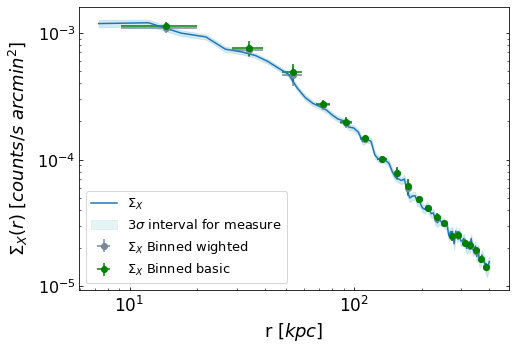

In [734]:
plt.figure(figsize=(7.7, 5.2))
plt.plot(r, SB , label='$\Sigma_X$')
plt.fill_between(r, SB_min, SB_max, color="lightblue", alpha=0.3, label='3$\sigma$ interval for measure')
    # Line plot with error bars
plt.errorbar(r_SB, SB_main, yerr=SB_stdv, xerr=r_SB_stdv, fmt='o', color='lightslategray', label='$\Sigma_X$ Binned wighted')  # Scatter plot with error barsà
plt.errorbar(r_SB, SB_basic, yerr=SB_stdv_basic, xerr=r_SB_stdv, fmt='o', color='green', label='$\Sigma_X$ Binned basic') 
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')
plt.fill_between(r, SB_min, SB_max, color="lightblue", alpha=0.3)

plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 

plt.show()

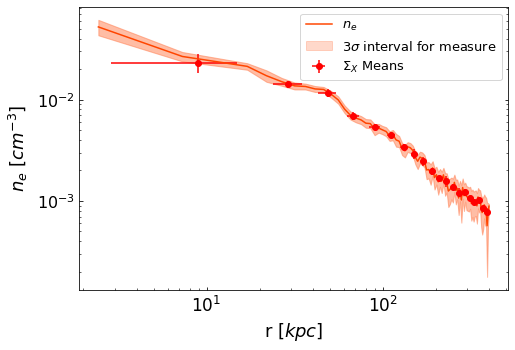

In [735]:
plt.figure(figsize=(7.7, 5.2))
plt.plot(r_el, n,  label='$n_e$', color="orangered")
plt.fill_between(r_el, n_min, n_max, color="coral", alpha=0.3, label='3$\sigma$ interval for measure')

plt.errorbar(r_n, n_main, yerr=n_stdv, xerr=r_n_stdv, fmt='o', color='red', label='$\Sigma_X$ Means')  
#plt.errorbar(r_means_el, n_means2, yerr=n_stds2, xerr=r_stds_el, fmt='o', color='chocolate', label='$n_e$ Means') 
plt.xscale('log')
plt.yscale('log')
plt.fill_between(r_el, n_min, n_max, color="coral", alpha=0.3)
plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$n_e$ [$cm^{-3}$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 

plt.show()

In [736]:
def beta_bright(b, I, r, beta):
    return I*np.power((1+(b/r)**2), 1/2-3*beta)

def duble_beta_b(b, I1, r1, beta1, I2, r2, beta2):
    return I1*np.power((1+(b/r1)**2), 1/2-3*beta1)+I2*np.power((1+(b/r2)**2), 1/2-3*beta2)

def beta_density(b, I, r, beta):
    return I*np.power((1+(b/r)**2), -3/2*beta)

def duble_beta_n(b, I1, r1, beta1, I2, r2, beta2):
    return I1*np.power((1+(b/r1)**2), -3/2*beta1)+I2*np.power((1+(b/r2)**2), -3/2*beta2)


In [737]:


#Fit for SB single beta model stts ok
guess=[1e-3, 35, 1]
popt, pcov = curve_fit(beta_bright, r_SB, SB_main, p0=guess, sigma=3*SB_stdv)
I_f, r_f, beta_f=popt
print("beta for single beta model SB is:")
print(beta_f)
print


#Fit for SB double beta model stts ok
guess=[1e-3, 50, 3, 1e-3, 50, 3]
popt, pcov = curve_fit(duble_beta_b, r_SB, SB_main, p0=guess, sigma=3*SB_stdv)
I_f2, r_f2, beta_f2, I2_f2, r2_f2, beta2_f2=popt



#Fit for density single beta model
guess=[1e-2, 33, 0.4]
popt, pcov = curve_fit(beta_density, r_n, n_main, p0=guess, sigma=3*n_stdv)
I_n, rr_n, beta_n=popt
print("beta for single beta model n is:")
print(beta_n)
print

#Fit duble beta model for electron density
guess=[0.003, 10, 0.5, 0.001, 20, 0.5]
popt, pcov = curve_fit(duble_beta_n, r_n, n_main, p0=guess, sigma=3*n_stdv)
I_n2, r_n2, beta_n2, I2_n2, r2_n2, beta2_n2=popt
print(popt)


###refit with simple statistics
guess=[1e-2, 50, 3]
popt, pcov = curve_fit(beta_bright, r_SB, SB_basic, p0=guess, sigma=3*SB_stdv_basic)
I_f_basic, r_f_basic, beta_f_basic=popt



guess=[1e-2, 50, 0.5]
popt, pcov = curve_fit(beta_density, r_n, n_basic, p0=guess, sigma=3*n_stdv_basic)
I_n_basic, r_n_basic, beta_n_basic=popt



beta for single beta model SB is:
0.47620672442039236
beta for single beta model n is:
0.4603276306000716
[2.17795752e-02 2.17906115e+01 3.79787398e-01 2.54547085e-03
 9.60666299e+03 4.78023956e+03]


0.47620672442039236


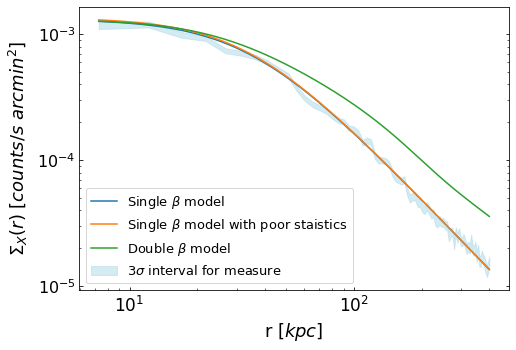

In [738]:
plt.figure(figsize=(7.7, 5.2))
rr=np.logspace(np.log10(np.min(r)), np.log10(np.max(r)), 1000)
 
plt.plot(rr, beta_bright(rr, I_f, r_f, beta_f), label=r"Single $ \beta$ model")
plt.plot(rr, beta_bright(rr, I_f_basic, r_f_basic, beta_f_basic), label=r"Single $\beta$ model with poor staistics")
plt.plot(rr,duble_beta_n(rr, I_f2, r_f2, beta_f2, I2_f2, r2_f2, beta2_f2), label=r"Double $\beta$ model" )
#plt.errorbar(r_means, SB_means2, yerr=SB_stds2, xerr=r_stds, fmt='o', label='$\Sigma_X$ Binned good')  # Scatter plot with error bars
#plt.errorbar(r_means, SB_means, yerr=SB_stds, xerr=r_stds, fmt='o', color='orange', label='$\Sigma_X$ Binned') 
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')
plt.fill_between(r, SB_min, SB_max, color="lightblue", label=r'3$\sigma$ interval for measure', alpha=0.5)

plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 
print(beta_f)
plt.show()

In [739]:
rr=np.logspace(np.log10(np.min(r_el)), np.log10(np.max(r_el)), 1000)

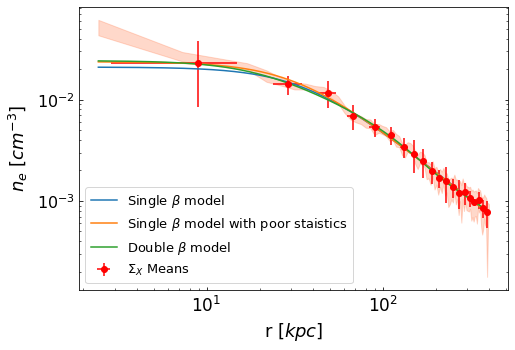

In [740]:

plt.figure(figsize=(7.7, 5.2))
plt.plot(rr, beta_density(rr,I_n, rr_n, beta_n), label=r"Single $ \beta$ model")
plt.plot(rr, beta_density(rr, I_n_basic, r_n_basic, beta_n_basic), label=r"Single $\beta$ model with poor staistics" )
plt.plot(rr,duble_beta_n(rr, I_n2, r_n2, beta_n2, I2_n2, r2_n2, beta2_n2), label=r"Double $\beta$ model" )

plt.errorbar(r_n, n_main, yerr=3*n_stdv, xerr=r_n_stdv, fmt='o', color='red', label='$\Sigma_X$ Means')  
#plt.errorbar(r_means_el, n_means2, yerr=2*n_stds2, xerr=r_stds_el, fmt='o', color='chocolate', label='$n_e$ Means') 
plt.xscale('log')
plt.yscale('log')
plt.fill_between(r_el, n_min, n_max, color="coral", alpha=0.3)
plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$n_e$ [$cm^{-3}$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 

plt.show()

We copy the T function form the article, we fit a beta model to have a function that gives back the T given the radius

In [741]:
r_T=np.array([40.6, 74.1, 113.3, 170, 256.4, 377.8])
kT=np.array([3.36, 3.82, 5.61, 4.58, 5.75, 5.07])
kT_maxerror=np.array([0.3, 0.3, 0.84, 0.48, 1, 0.36])
kT_minerror=np.array([0.24, 0.33, 0.7, 0.39, 0.88, 0.35])
kT_error = [kT - kT_minerror, kT_maxerror - kT]

def T_clus(b, I, r, beta):
    return I*np.power((1+(b/r)**2), 3/2*beta)

kT_error = (kT_maxerror + kT_minerror)/2

ppot, covp= curve_fit(T_clus, r_T, kT , sigma=kT_error, p0=[1.23402149, 0.08747063, 0.06041828])

T_F, r_TT, alpha=ppot



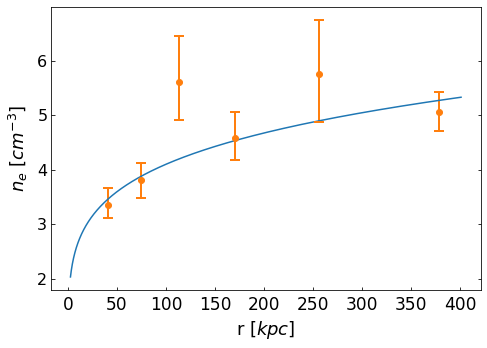

In [742]:
plt.figure(figsize=(7.7, 5.2))

plt.plot(rr, T_clus(rr, T_F, r_TT, alpha) )
plt.errorbar(r_T, kT, 
             yerr=[kT_minerror, kT_maxerror], 
             fmt='o', 
             
             capsize=5, 
             capthick=2, 
             elinewidth=2, 
             label='kT with error bars')


plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$n_e$ [$cm^{-3}$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')


plt.show()

In [743]:
sigma_f=(np.sqrt(beta_f*5*erg/(mu*m_p)))*1e-5

print("The velocity dispersion is")
print(sigma_f)


kT=T_clus(r_SB, T_F, r_TT, alpha)

The velocity dispersion is
616.6584051016157


In [744]:
def beta_bright_T(inputs, I, r, sigma):
    
    b, kT = inputs
    mu = 0.6
    m_p = 1.672e-24
    return I * np.power((1 + (b / r) ** 2), 1/2 - 3 * ((sigma ** 2)*(mu * m_p)/kT ))

inputs = (r_SB, kT*erg)
guess=[1e-3, 50, 1e7]

popt, pcov = curve_fit(beta_bright_T, inputs, SB_main, p0=guess, sigma=3*SB_stdv)
I_T, rr_T, sigma_T=popt







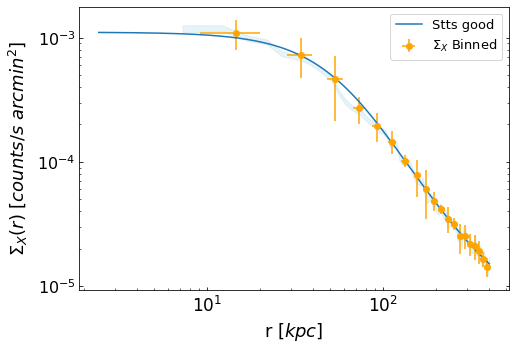

In [745]:

T=T_clus(rr, T_F, r_TT, alpha)
inp=(rr, T*erg)

plt.figure(figsize=(7.7, 5.2))
plt.plot(rr, beta_bright_T(inp,I_T, rr_T, sigma_T), label="Stts good")


plt.errorbar(r_SB, SB_main, yerr=3*SB_stdv, xerr=r_SB_stdv, fmt='o', color='orange', label='$\Sigma_X$ Binned') 
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')
plt.fill_between(r, SB_min, SB_max, color="lightblue", alpha=0.3)

plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 


In [746]:
##getting the T for the radius of the binns
kT=T_clus(r_n, T_F, r_TT, alpha)
inputs = (r_n, kT*erg)

###SIngle beta model for n

def beta_n_T(inputs, I, r, sigma):
    
    b, kT = inputs
    mu = 0.6
    m_p = 1.672e-24
    return I * np.power((1 + (b / r) ** 2), - 3/2 * ((sigma ** 2)*(mu * m_p)/kT ))



guess=[1e-3, 50, 1e7]

popt, pcov = curve_fit(beta_n_T, inputs, n_main, p0=guess, sigma=n_stdv)
I_n_T, r_n_T, sigma_n_T=popt



###Double beta model for n#####

def duble_beta_n_T(inputs, I, r, sigma, I2, r2, sigma2):
    
    b, kT = inputs
    mu = 0.6
    m_p = 1.672e-24
    return I * np.power((1 + (b / r) ** 2), - 3/2 * ((sigma ** 2)*(mu * m_p)/kT ))+I2 * np.power((1 + (b / r2) ** 2), - 3/2 * ((sigma2 ** 2)*(mu * m_p)/kT ))

guess=[1e-3, 50, 1e7, 1e-3, 50, 1e7]

popt, pcov = curve_fit(duble_beta_n_T, inputs, n_main, p0=guess, sigma=n_stdv)
I_n_T2, r_n_T2, sigma_n_T2, I_n_T22, r_n_T22, sigma_n_T22=popt

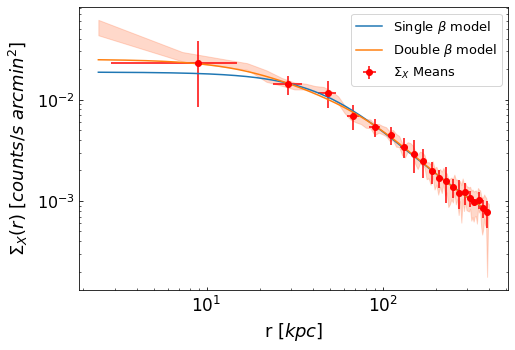

In [747]:
T=T_clus(rr, T_F, r_TT, alpha)
inp=(rr, T*erg)

plt.figure(figsize=(7.7, 5.2))
plt.plot(rr, beta_n_T(inp, I_n_T, r_n_T, sigma_n_T), label=r"Single $ \beta$ model")
plt.plot(rr, duble_beta_n_T(inp, I_n_T2, r_n_T2, sigma_n_T2, I_n_T22, r_n_T22, sigma_n_T22), label=r"Double $\beta$ model")

plt.errorbar(r_n, n_main, yerr=3*n_stdv, xerr=r_n_stdv, fmt='o', color='red', label='$\Sigma_X$ Means')  
#plt.errorbar(r_means_el, n_means2, yerr=2*n_stds2, xerr=r_stds_el, fmt='o', color='chocolate', label='$n_e$ Means') 
plt.xscale('log')
plt.yscale('log')
plt.fill_between(r_el, n_min, n_max, color="coral", alpha=0.3)
plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 
    

In [748]:
r_T=np.array([40.6, 74.1, 113.3, 170, 256.4, 377.8])
kT=np.array([3.36, 3.82, 5.61, 4.58, 5.75, 5.07])
kT_maxerror=np.array([0.3, 0.3, 0.84, 0.48, 1, 0.36])
kT_minerror=np.array([0.24, 0.33, 0.7, 0.39, 0.88, 0.35])
kT_error = [kT - kT_minerror, kT_maxerror - kT]

indices = np.abs(r_SB[:, np.newaxis] - r_T).argmin(axis=1)

# Assign kT values based on nearest r_T
step_T = kT[indices]
    


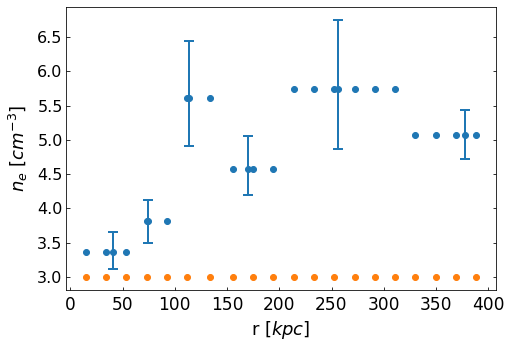

In [749]:
plt.figure(figsize=(7.7, 5.2))

plt.scatter(r_SB,  step_T)
plt.scatter(r_SB, 3*np.ones(len(r_SB)))
plt.errorbar(r_T, kT, 
             yerr=[kT_minerror, kT_maxerror], 
             fmt='o', 
             
             capsize=5, 
             capthick=2, 
             elinewidth=2, 
             label='kT with error bars')


plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$n_e$ [$cm^{-3}$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')


plt.show()

In [750]:
inputs = (r_SB, step_T*erg)

guess=[100, 1, 3e7]

popt, pcov = curve_fit(beta_bright_T, inputs, SB_main, p0=guess, sigma=3*SB_stdv)
I_T, rr_T, sigma_T=popt


inputs = (r_n, step_T*erg)

guess=[100, 1, 3e7]

popt, pcov = curve_fit(beta_n_T, inputs, n_main, p0=guess, sigma=3*n_stdv)
I_n_T, rr_n_T, sigma_n_T=popt


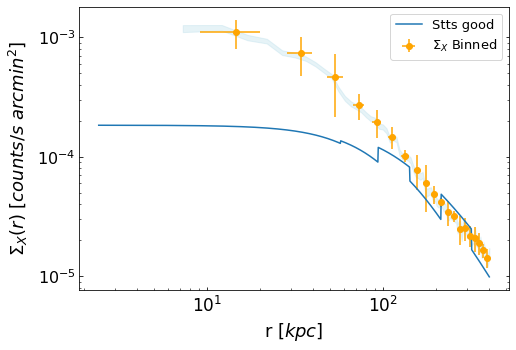

In [751]:
indices = np.abs(rr[:, np.newaxis] - r_T).argmin(axis=1)

# Assign kT values based on nearest r_T
T = kT[indices]
inp=(rr, T*erg)

plt.figure(figsize=(7.7, 5.2))
plt.plot(rr, beta_bright_T(inp,I_T, rr_T, sigma_T), label="Stts good")


plt.errorbar(r_SB, SB_main, yerr=3*SB_stdv, xerr=r_SB_stdv, fmt='o', color='orange', label='$\Sigma_X$ Binned') 
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')
plt.fill_between(r, SB_min, SB_max, color="lightblue", alpha=0.3)

plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 


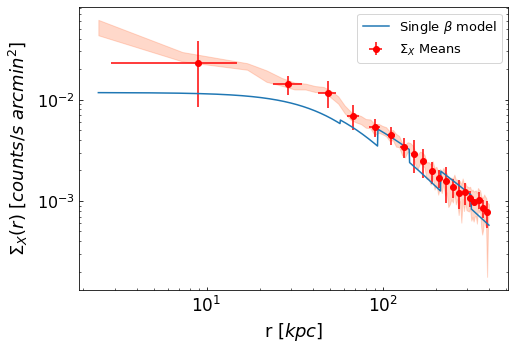

In [752]:
plt.figure(figsize=(7.7, 5.2))
plt.plot(rr, beta_n_T(inp, I_n_T, r_n_T, sigma_n_T), label=r"Single $ \beta$ model")

plt.errorbar(r_n, n_main, yerr=3*n_stdv, xerr=r_n_stdv, fmt='o', color='red', label='$\Sigma_X$ Means')  
#plt.errorbar(r_means_el, n_means2, yerr=2*n_stds2, xerr=r_stds_el, fmt='o', color='chocolate', label='$n_e$ Means') 
plt.xscale('log')
plt.yscale('log')
plt.fill_between(r_el, n_min, n_max, color="coral", alpha=0.3)
plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$\Sigma_X(r)$ [$counts/s$ $arcmin^2$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')
plt.legend(fontsize=13) 

We use the fit fot the T in Vikhlininet al. (2006)

In [753]:
r_T=np.array([40.6, 74.1, 113.3, 170, 256.4, 377.8])
kT=np.array([3.36, 3.82, 5.61, 4.58, 5.75, 5.07])
kT_maxerror=np.array([0.3, 0.3, 0.84, 0.48, 1, 0.36])
kT_minerror=np.array([0.24, 0.33, 0.7, 0.39, 0.88, 0.35])
kT_error = [kT - kT_minerror, kT_maxerror - kT]


def T_v(r, r_1, a, b, c, r_cool, a_cool):
    t_cool=(r/r_1)**(-a)/((1+(r/r_1)**(b))**(c/b))
    x=(r/r_cool)**(a_cool)
    T_T=(x+3.5/5)/(x+1)
    return t_cool*T_T

In [754]:
guess=[1.36665553e+01, -1.87787988e-01,  1.02944116e-03, -1.53986968e-03,
  8.10019439e-06,  3.74354604e+01]
kT_error = (kT_maxerror + kT_minerror)/2
ppot, covp= curve_fit(T_v, r_T, kT , sigma=kT_error, p0=guess)

r_1, a, b, c, r_cool, a_cool=ppot
print(ppot)

[ 1.37024625e+01 -1.87788863e-01  1.02778728e-03 -1.53813014e-03
  8.10019439e-06  3.74354604e+01]


/Users/lorenzovannini/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


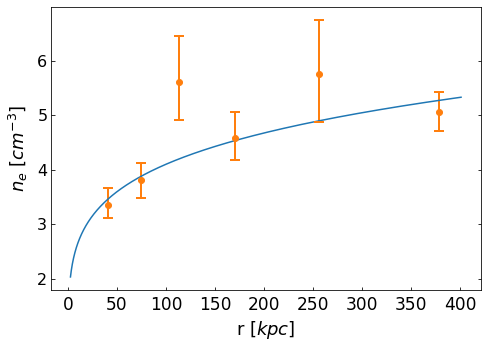

In [755]:
plt.figure(figsize=(7.7, 5.2))

plt.plot(rr, T_v(rr, r_1, a, b, c, r_cool, a_cool) )
plt.errorbar(r_T, kT, 
             yerr=[kT_minerror, kT_maxerror], 
             fmt='o', 
             
             capsize=5, 
             capthick=2, 
             elinewidth=2, 
             label='kT with error bars')


plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')


plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$n_e$ [$cm^{-3}$]', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')


plt.show()

In [756]:
T=T_clus(rr, T_F, r_TT, alpha)
inp=(rr, T*erg)

rho_T=m_p*mu*duble_beta_n_T(inp, I_n_T2, r_n_T2, sigma_n_T2, I_n_T22, r_n_T22, sigma_n_T22)

In [757]:
M_tot = np.zeros(len(rr)) 
for i in range(len(rr) - 1):
    # Calculate the volume element between rr[i] and rr[i+1]
    shell_volume = (4 * np.pi / 3) * ((rr[i+1] * kpc)**3*rho_T[i+1]  + rho_T[i]*(rr[i] * kpc)**3)
    
    # Approximate the density in the shell using the trapezoidal rule
     
    
    # Increment mass by the mass of the current shell
    shell_mass = shell_volume
    
    # Accumulate the total mass
    M_tot[i+1] = M_tot[i] + shell_mass

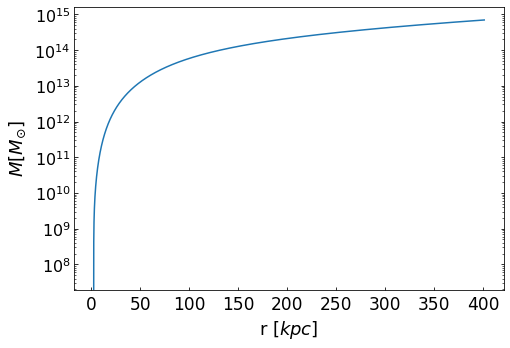

In [758]:
plt.figure(figsize=(7.7, 5.2))

plt.plot(rr, M_tot/g)


plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')
plt.yscale("log")

plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$M[M_{\odot}]$', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')


plt.show()

In [759]:
T=T_clus(rr, T_F, r_TT, alpha)
M_tot_an = np.zeros(len(rr))
for i in range(len(rr) - 1):
    beta=(sigma_n_T**2*mu*m_p)/(erg*T[i])
    
    M_tot_an[i+1]=(rr[i]*kpc*T[i]*erg)/(G*mu*m_p)*((3*beta*((rr[i]*kpc)**2))/((rr[i]*kpc)**2+(r_n_T*kpc)**2)+((np.log(erg*T[i+1])-np.log(erg*T[i]))/(np.log(kpc*rr[i+1])-np.log(kpc*rr[i]))))

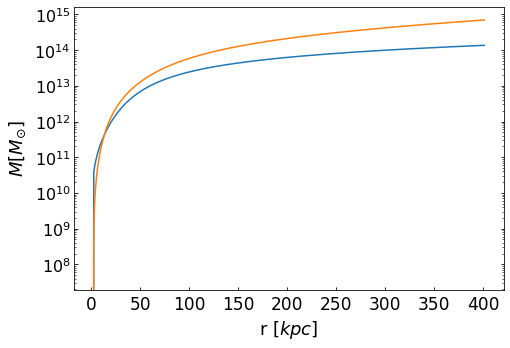

In [760]:
plt.figure(figsize=(7.7, 5.2))

plt.plot(rr, M_tot_an/g)
plt.plot(rr, M_tot/g)

plt.xticks(fontsize=17)
plt.yticks(fontsize=16)
plt.tick_params(axis='x', which='both', direction='in', pad=6)  # Adjust pad to move x tick labels lower
plt.tick_params(axis='y', which='both', direction='in')
plt.yscale("log")

plt.xlabel('r $[kpc]$', fontsize=18, labelpad=5)
plt.ylabel(r'$M[M_{\odot}]$', fontsize=18,labelpad=7)
plt.tick_params(axis='both', direction='in', which='both')
ax = plt.gca()  # Get the current axes
ax.yaxis.set_ticks_position('both')  # Show ticks on both sides
ax.tick_params(axis='y', which='both', direction='in')


plt.show()

In [761]:
SB=numbers[:, 0]
SB_error=numbers[:, 1]
r=numbers[:, 2]

SB_min=SB-SB_error
SB_max=SB+SB_error

n=electro[:, 0]
n_error=electro[:, 1]
r_el=electro[:, 2]

n_min=n-n_error
n_max=n+n_error